Step 1: build a surface water network. You can "pickle" this, so it doesn't need to be repeated.

n = swn.SurfaceWaterNetwork.from_lines(gdf.geometry)

n.to_pickle("surface-water-network.pkl")

# then in a later session, skip the above and just do:

n = swn.SurfaceWaterNetwork.from_pickle("surface-water-network.pkl")

Step 2: load a MF6 model, then find the intersections:

sim = flopy.mf6.MFSimulation.load(...)

m = sim.get_model(...)

nm = swn.SwnMf6.from_swn_flopy(n, m)

Most of the results will be in the nm.reaches property, but other reach datasets will need to be specified, including "man", "rbth", "rgrd", "rhk", "rtp", and "rwid". There are two methods to format the PACKAGEDATA:

nm.flopy_packagedata

nm.write_packagedata("packagedata.dat")

Similar with CONNECTIONDATA:

nm.flopy_connectiondata

nm.write_connectiondata("connectiondata.dat")

There are a few "helper" methods to sort out things like "set_reach_slope" based on a few methods. One missing one is "set_reach_elevation" or whatever to make the reaches fit in the layer and/or move the layer elevations to fit the stream.

And lastly, there is no PERIOD data yet. I'm working on this, which is holding up the merge.


In [12]:
import geopandas
import os
import swn
import flopy
import numpy as np
import time
import pandas as pd

# SW network pickle

#only do this once... takes forever... then load pickle
gdb_dir = 'D:\modelling\data'
gdb_fname = 'nzRec2_v5.gdb'
gdb_path = os.path.join(gdb_dir, gdb_fname)
# Read national data of streams
gdf_lines = geopandas.read_file(gdb_path, layer='riverlines')
gdf_lines.set_index('nzsegment', inplace=True, verify_integrity=True)
gdf_ws = geopandas.read_file(gdb_path, layer='rec2ws')
gdf_ws.set_index('nzsegment', inplace=True, verify_integrity=True)
# Convert MultiLineString -> LineString
lines = gdf_lines.geometry.apply(lambda x: x.geoms[0]) #what is geoms[0]
polygons = gdf_ws.geometry.apply(lambda x: x.geoms[0])
#ni_lines = gdf_lines.loc[gdf_lines.index < 10000000, "geometry"]
# requires reindex otherwise failure in core.from_lines
t0=time.time()
n = swn.SurfaceWaterNetwork.from_lines(lines,polygons.reindex(index=lines.index))
print(time.time()-t0)
n.to_pickle("surface-water-network.pkl")

# get the pickle

In [13]:
n = swn.SurfaceWaterNetwork.from_pickle("surface-water-network.pkl")

# Load MF6 model

In [14]:
os.getcwd()

'D:\\modelling\\surface-water-network'

In [15]:
sim_ws=os.path.join('..','zmodels','20210622_simulation','wairau_240_3')
model_name='wairau_240_3'
sim=flopy.mf6.MFSimulation.load(sim_ws=sim_ws)
gwf=sim.get_model(model_name)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package ghb...
    loading package rch...
    loading package drn...
    loading package npf...
    loading package sto...
    loading package oc...
  loading ims package wairau_240_3...


## spatial reference for model

In [16]:
#sr=flopy.utils.reference.SpatialReference.from_gridspec(os.path.join(sim_ws,model_name+'.grid.spc'))
#gwf.dis.xorigin=sr.xul
#gwf.dis.yorigin=sr.yul-np.sum(gwf.dis.delr.data)
#gwf.dis.write()

In [17]:
type(gwf)

flopy.mf6.mfmodel.MFModel

In [18]:
# this also takes forever
t0=time.time()
ngwf = swn.SwnMf6.from_swn_flopy(n, gwf,reach_include_fraction=0)
print(time.time()-t0)

409.6421043872833


In [19]:
gwf.dis.botm[0].fname

'wairau_240_3.dis_botm_layer1.txt'

In [20]:
# https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-sfr.html?highlight=ustrf#block-packagedata
# started from sagehen example, tweaked
# can do ngwf.default_packagedata() now?
d={'rwid':10.0,'man':0.04,'ustrf':1.0,'ndv': 0}
for k in ["man", "rwid"]:
    ngwf.reaches[k]=d[k]

# was taking much time to fail with no zcoord, now takes 1.2 sec
t0=time.time()
#zcoord_ab or grid_top
try:
    ngwf.set_reach_slope(method='zcoord_ab')
except:
    print(time.time()-t0)


In [21]:
# check for nans, should have been fixed, taken care of
ngwf.set_reach_slope(method='top_len')

15:32:23.605:WARNING:SwnMf6:enforcing min_slope for 132 reaches (0.33%)


In [26]:
# no rno=0 so missing labels error, floats because of nans
# mintop is way higher than top, top must have been filtered differently
mintop=np.loadtxt(os.path.join(sim_ws,model_name+'.mintop.dat'))
top=gwf.dis.top.array
botm=gwf.dis.botm.array
ngwf.set_reach_data_from_array("rtp", top)

In [27]:
t0=time.time()
df=ngwf.reaches.copy()
rdf=ngwf.reaches.copy()
df['ij']=df.apply(lambda x: (x['i'],x['j']),axis=1)
for idx,r in df.iterrows():
    trno=int(r['to_rno'])
    if trno!=0:
        #rdf.loc[idx,'ti']=int(df.loc[trno,'i'])
        #rdf.loc[idx,'tj']=int(df.loc[trno,'j'])
        rdf.loc[idx,'to_rtp']=df.loc[trno,'rtp']
#rdf['titj']=rdf.apply(lambda x: (int(x['ti']),int(x['tj'])),axis=1)
print(time.time()-t0)

29.155561447143555


In [24]:
mintop[389,55]

1100.1292809263455

In [25]:
top[389,55]

1098.1763155826266

In [29]:
rdf.loc[:,'rbth']=2

In [31]:
loop=0
cont=True
mindz=0.001
minincise=1.0
minthick=1.0
while cont:
    bad_reaches=[i for i in rdf.index if rdf.loc[i,'to_rtp']>rdf.loc[i,'rtp']-mindz]
    loop=loop+1
    chg=0
    for br in bad_reaches:
        rno=br
        trno=int(rdf.loc[br,'to_rno'])
        chglist=[]
        if trno!=0:
            c=1
            while trno!=0 and rdf.loc[trno,'rtp']>rdf.loc[rno,'rtp']-mindz*c:
                # keep list of dz in case another inflowing stream is even lower
                chglist.append(trno)
                nelev=rdf.loc[rno,'rtp']-mindz*c
                # set to_rtp and rtp
                rdf.loc[rno,'to_rtp']=nelev                
                rdf.loc[trno,'rtp']=nelev
                # get new to_rno 
                rno=trno
                trno=df.loc[rno,'to_rno']
                c=c+1
                
            # now adjust layering if necessary
            if len(chglist)>0:
                for r in chglist:
                    ij=(int(rdf.loc[r,'i']),int(rdf.loc[r,'j']))
                    
                    # bump top elev up to rtp
                    if top[ij]<rdf.loc[r,'rtp']:
                        top[ij]=rdf.loc[r,'rtp']+minincise
                    # bump bottoms down if needed
                    if botm[0][ij]>=rdf.loc[r,'rtp']-(rdf.loc[r,'rbth']+minthick):
                        dz=botm[0][ij]-(rdf.loc[r,'rtp']-(rdf.loc[r,'rbth']+minthick))
                        for b in range(0,botm.shape[0]):
                            botm[b][ij]=botm[b][ij]-dz
                        
        chg=chg+len(chglist)
    if chg==0:
        cont=False
    else:
        print('{} changed in loop {}'.format(chg,loop))

14294
13464 changed in loop 1
4082


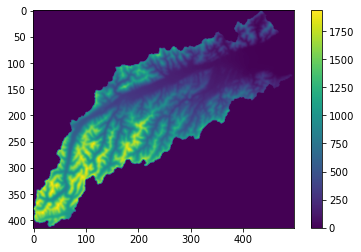

In [32]:
import matplotlib.pyplot as plt
plt.imshow(top)
plt.colorbar()

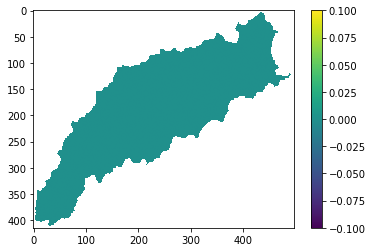

In [40]:
i=1
plt.imshow(gwf.dis.botm[i].array-gwf.dis.botm[i-1].array)
plt.colorbar()

In [36]:
np.max(gwf.dis.top.array-top)

0.0

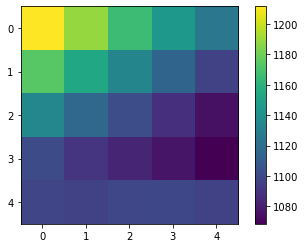

In [35]:
plt.imshow(top[385:390,55:60])
plt.colorbar()

In [ ]:
top[389,55]

In [ ]:
rdf.loc[(rdf['i']==389) & (rdf['j']==55),:]

In [ ]:
f=gwf.dis.top.get_file_entry().split("'")[1]
fpth=os.path.join(sim_ws+'_sfr',f)
np.savetxt(f,top)

In [ ]:
for b in range(0,botm.shape[0]):
    f=gwf.dis.botm[b].fname
    fpth=os.path.join(sim_ws+'_sfr',f)
    np.savetxt(f,botm[b])

In [ ]:
ngwf.reaches=rdf

In [ ]:
ngwf.set_reach_data_from_array('rhk',gwf.npf.k.array[0])

In [ ]:
n.segments.to_csv(os.path.join(sim_ws+'_sfr',model_name+'_znseg_mf6rch.csv'))

In [ ]:
mask=[s for s in n.segments.index if (len(n.segments.loc[s,'from_segnums'])==0) & (n.segments.loc[s,'to_segnum']==0)]

In [ ]:
len(mask)

In [ ]:
n.segments.drop(mask,inplace=True)

In [ ]:


# There are two methods to format the PACKAGEDATA:
ngwf.flopy_packagedata
ngwf.write_packagedata(os.path.join(sim_ws+'_sfr',model_name+'.sfr0.reach.dat'))

#Similar with CONNECTIONDATA:
ngwf.flopy_connectiondata
ngwf.write_connectiondata(os.path.join(sim_ws+'_sfr',model_name+'.sfr0.connection.dat'))


In [ ]:
sfr=flopy.mf6.ModflowGwfsfr(gwf,packagedata={'filename':model_name+'.sfr0.reach.dat'},
                            connectiondata={'filename':model_name+'.sfr0.connection.dat'},
                           nreaches=len(ngwf.reaches),budget_filerecord=model_name + "_sfr.bud",
                            save_flows=True)
#gwf.register_package(sfr)
sfr.write()

In [ ]:
model_name

In [ ]:
gwf.write()

In [ ]:
help(ngwf)

# write shapefile, but not sfr info from grid intersection

In [ ]:
swn.file.gdf_to_shapefile(n.segments, 'segments.shp')